<a href="https://colab.research.google.com/github/giuseppemartino26/AirAlcala/blob/master/ResNet50_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Questo notebook contiene gli esperimenti usando il modello pre-allenato ResNet50 per il task di classificazione multi classe.

In [ ]:
import os
import numpy as np
import tensorflow as tf
import random as rn
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def show_curves(history):
  '''
  plot training and validation accuracy and loss curves
  :param history
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
def evaluate_multiclass_model(model_path, test_dataset):
  '''
    plot the confusion matrix and ROC curve
    :param: model_path: path where the model is located
    :param test_dataset
  '''
  model = load_model(model_path)
  y_pred = model.predict(test_dataset)
  y_pred = np.argmax(y_pred, axis=1)
  y_true = np.concatenate([y for x, y in test_dataset], axis=0)
  y_true = np.argmax(y_true, axis=1)
  print("Classification report: ")
  print(classification_report(y_true,y_pred))

  # matrice di confusione
  confusion_matrix = metrics.confusion_matrix(y_true, y_pred, normalize='true')
  fig, ax = plt.subplots(figsize=(10, 8))
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
  disp.plot(ax=ax)
  plt.show()

In [ ]:
def train_model(model, patience, epochs):
  save_path = '/content/actual_model.h5'

  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience = patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

  history = model.fit(train_dataset,
                    epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  return history

In [ ]:
def save_model (model_name):
  dir_name = '/content/drive/MyDrive/Colab Notebooks/CIDL Project/saved_models'
  if not os.path.exists(dir_name):
    os.makedirs(dir_name)

  model.save(os.path.join(dir_name, model_name))

Carico il dataset

In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/CIDL Project/Dataset_splitted_multi.zip' -d '/content'

In [ ]:
dataset_path = '/content/Dataset'
training_set_path = '/content/Dataset/training_set'
validation_set_path = '/content/Dataset/validation_set'
test_set_path = '/content/Dataset/test_set'

#raddoppiamo le dimensioni, altrimenti troppo piccole per essere accettate dalla rete
BATCH_SIZE = 32
IMAGE_HEIGHT = 80
IMAGE_WIDTH = 48

In [ ]:
# The below is necessary for reproducible results of certain Python hash-based operations.
os.environ["PYTHONHASHSEED"]="0"
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(31)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(14)
# The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
tf.random.set_seed(1234)


In [ ]:
train_dataset = image_dataset_from_directory(
    training_set_path,
    label_mode = 'categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    validation_set_path,
    label_mode = 'categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

test_dataset = image_dataset_from_directory(
    test_set_path,
    label_mode = 'categorical',
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle = False)

Found 13535 files belonging to 12 classes.
Found 3995 files belonging to 12 classes.
Found 3995 files belonging to 12 classes.


In [ ]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 80, 48, 3)
labels batch shape: (32, 12)


Istanziamo il modello ResNet50.

In [ ]:
conv_base = keras.applications.resnet.ResNet50(
    weights="imagenet",
    include_top=False, #non includiamo il layer fully connected
    input_shape=(80, 48, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 86, 54, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 40, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 40, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [ ]:
import numpy as np

print('This is the number of trainable weights '
      'before freezing the conv base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 23534592


In [ ]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', sum(np.prod(x.shape) for x in conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [ ]:
data_augmentation = keras.Sequential(
  [
  layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='wrap'),
   #layers.RandomFlip(),
   #layers.RandomBrightness(factor=0.11),
   #tf.keras.layers.RandomRotation(factor=1.0, fill_mode='reflect', interpolation='nearest')
  ]
)

## Feature Extraction

### Experiment 1: adding just one fc layer to the conv base

In [ ]:
inputs = keras.Input(shape=(80, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
outputs = layers.Dense(12, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 80, 48, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 80, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 80, 48, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                             

In [ ]:
save_path = '/content/actual_model.h5'

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/20


423/423 [==============================] - ETA: 0s - loss: 2.1764 - accuracy: 0.4226
Epoch 1: val_loss improved from inf to 2.40056, saving model to /content/actual_model.h5
423/423 [==============================] - 77s 151ms/step - loss: 2.1764 - accuracy: 0.4226 - val_loss: 2.4006 - val_accuracy: 0.3374
Epoch 2/20
423/423 [==============================] - ETA: 0s - loss: 1.8758 - accuracy: 0.5011
Epoch 2: val_loss improved from 2.40056 to 2.35619, saving model to /content/actual_model.h5
423/423 [==============================] - 64s 150ms/step - loss: 1.8758 - accuracy: 0.5011 - val_loss: 2.3562 - val_accuracy: 0.4313
Epoch 3/20
423/423 [==============================] - ETA: 0s - loss: 1.8318 - accuracy: 0.5252
Epoch 3: val_loss improved from 2.35619 to 1.75440, saving model to /content/actual_model.h5
423/423 [==============================] - 57s 135ms/step - loss: 1.8318 - accuracy: 0.5252 - val_loss: 1.7544 - val_accuracy: 0.5232
Epoch 4/20
423/423 [==========================

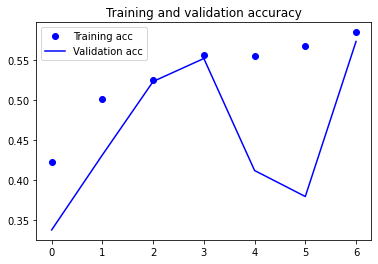

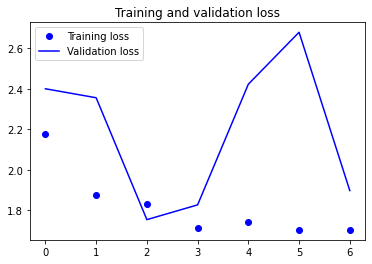

In [ ]:
show_curves(history)

### Experiment 2: one more fc layer

In [ ]:
inputs = keras.Input(shape=(80, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.5) (x)
#x = layers.Dense(1000, activation='relu') (x)
#x = layers.Dropout(0.5) (x)
x = layers.Dense(500, activation='relu') (x)
#x = layers.Dropout(0.5) (x)
outputs = layers.Dense(12, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 80, 48, 3)         0         
                                                                 
 tf.__operators__.getitem_1   (None, 80, 48, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 80, 48, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 12288)             0   

In [ ]:
save_path = '/content/resnet_multi_2_fc.h5'

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/20


423/423 [==============================] - ETA: 0s - loss: 1.7767 - accuracy: 0.4296
Epoch 1: val_loss improved from inf to 1.69641, saving model to /content/resnet_multi_2_fc.h5
423/423 [==============================] - 64s 137ms/step - loss: 1.7767 - accuracy: 0.4296 - val_loss: 1.6964 - val_accuracy: 0.3982
Epoch 2/20
423/423 [==============================] - ETA: 0s - loss: 1.3653 - accuracy: 0.5269
Epoch 2: val_loss improved from 1.69641 to 1.42656, saving model to /content/resnet_multi_2_fc.h5
423/423 [==============================] - 58s 137ms/step - loss: 1.3653 - accuracy: 0.5269 - val_loss: 1.4266 - val_accuracy: 0.5279
Epoch 3/20
423/423 [==============================] - ETA: 0s - loss: 1.2642 - accuracy: 0.5620
Epoch 3: val_loss improved from 1.42656 to 1.41345, saving model to /content/resnet_multi_2_fc.h5
423/423 [==============================] - 57s 135ms/step - loss: 1.2642 - accuracy: 0.5620 - val_loss: 1.4135 - val_accuracy: 0.5079
Epoch 4/20
423/423 [===========

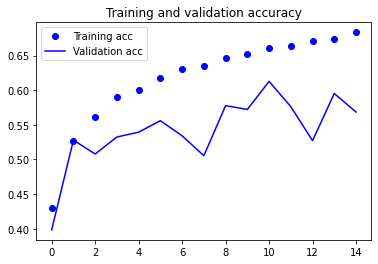

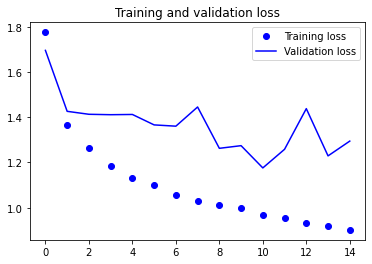

In [ ]:
show_curves(history)

In [ ]:
save_model(save_path)

### Experiment 3: two more fc layers

In [ ]:
inputs = keras.Input(shape=(80, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu') (x)
x = layers.Dense(512, activation='relu') (x)
outputs = layers.Dense(12, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 80, 48, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 80, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 80, 48, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                             

In [ ]:
model_name = 'resnet_multi_3_fc.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=6),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/20


512/512 [==============================] - ETA: 0s - loss: 1.7366 - accuracy: 0.4334
Epoch 1: val_loss improved from inf to 1.72409, saving model to /content/resnet_multi_3_fc.h5
512/512 [==============================] - 93s 151ms/step - loss: 1.7366 - accuracy: 0.4334 - val_loss: 1.7241 - val_accuracy: 0.3765
Epoch 2/20
512/512 [==============================] - ETA: 0s - loss: 1.3575 - accuracy: 0.5238
Epoch 2: val_loss improved from 1.72409 to 1.25885, saving model to /content/resnet_multi_3_fc.h5
512/512 [==============================] - 73s 143ms/step - loss: 1.3575 - accuracy: 0.5238 - val_loss: 1.2588 - val_accuracy: 0.5752
Epoch 3/20
512/512 [==============================] - ETA: 0s - loss: 1.2392 - accuracy: 0.5665
Epoch 3: val_loss did not improve from 1.25885
512/512 [==============================] - 73s 142ms/step - loss: 1.2392 - accuracy: 0.5665 - val_loss: 1.2990 - val_accuracy: 0.5635
Epoch 4/20
512/512 [==============================] - ETA: 0s - loss: 1.1720 - acc

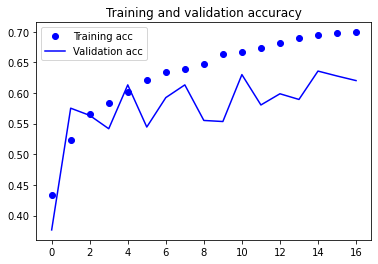

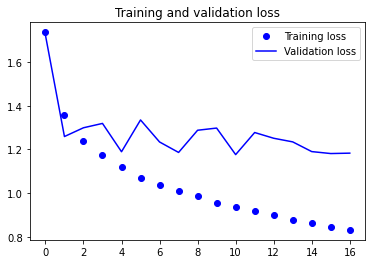

In [ ]:
show_curves(history)

In [ ]:
save_model(model_name)

125/125 [==============================] - 3s 17ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.57      0.39      0.46       375
           1       0.39      0.37      0.38       257
           2       0.58      0.59      0.58       188
           3       0.60      0.69      0.64       299
           4       0.20      0.63      0.31        35
           5       0.19      0.61      0.29        49
           6       0.23      0.57      0.32        49
           7       0.89      0.72      0.79      2000
           8       0.27      0.49      0.35       165
           9       0.52      0.51      0.51       211
          10       0.14      0.45      0.21        40
          11       0.58      0.57      0.57       327

    accuracy                           0.62      3995
   macro avg       0.43      0.55      0.45      3995
weighted avg       0.69      0.62      0.64      3995



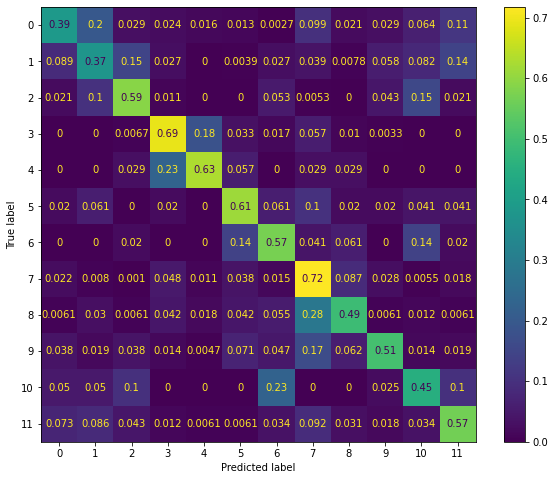

In [ ]:
evaluate_multiclass_model('/content/drive/MyDrive/Colab Notebooks/CIDL Project/saved_models/resnet_multi_3_fc.h5', test_dataset)

### Experiment 4: adding dropout

In [ ]:
inputs = keras.Input(shape=(80, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(1000, activation='relu') (x)
x = layers.Dense(500, activation='relu') (x)
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(12, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 80, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 80, 48, 3)         0         
                                                                 
 tf.__operators__.getitem_2   (None, 80, 48, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 80, 48, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 12288)             0   

In [ ]:
model_name = 'resnet_multi_dropout.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=6),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/20


423/423 [==============================] - ETA: 0s - loss: 2.0117 - accuracy: 0.3494
Epoch 1: val_loss improved from inf to 1.56175, saving model to /content/resnet_multi_dropout.h5
423/423 [==============================] - 69s 150ms/step - loss: 2.0117 - accuracy: 0.3494 - val_loss: 1.5618 - val_accuracy: 0.4746
Epoch 2/20
423/423 [==============================] - ETA: 0s - loss: 1.5960 - accuracy: 0.4542
Epoch 2: val_loss did not improve from 1.56175
423/423 [==============================] - 60s 142ms/step - loss: 1.5960 - accuracy: 0.4542 - val_loss: 1.6432 - val_accuracy: 0.4596
Epoch 3/20
423/423 [==============================] - ETA: 0s - loss: 1.4802 - accuracy: 0.4924
Epoch 3: val_loss did not improve from 1.56175
423/423 [==============================] - 64s 150ms/step - loss: 1.4802 - accuracy: 0.4924 - val_loss: 1.5981 - val_accuracy: 0.4566
Epoch 4/20
423/423 [==============================] - ETA: 0s - loss: 1.3845 - accuracy: 0.5234
Epoch 4: val_loss improved from 1.

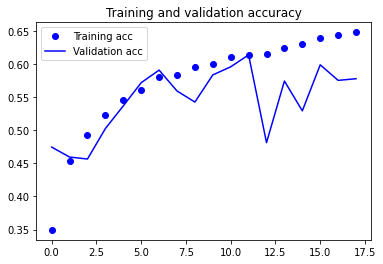

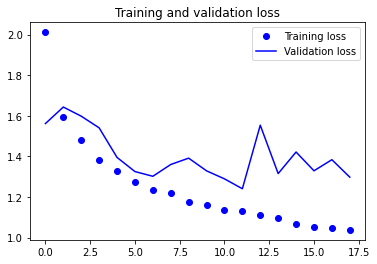

In [ ]:
show_curves(history)

In [ ]:
save_model(model_name)

### Experiment 5: Batch normalization

In [ ]:
inputs = keras.Input(shape=(80, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(1024) (x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Dense(512) (x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
outputs = layers.Dense(12, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 80, 48, 3)         0         
                                                                 
 tf.__operators__.getitem_1   (None, 80, 48, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 80, 48, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 12288)             0   

In [ ]:
model_name = 'resnet_multi_BN.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/40


423/423 [==============================] - ETA: 0s - loss: 1.6606 - accuracy: 0.4427
Epoch 1: val_loss improved from inf to 1.46253, saving model to /content/resnet_multi_BN.h5
423/423 [==============================] - 75s 156ms/step - loss: 1.6606 - accuracy: 0.4427 - val_loss: 1.4625 - val_accuracy: 0.5109
Epoch 2/40
423/423 [==============================] - ETA: 0s - loss: 1.3429 - accuracy: 0.5344
Epoch 2: val_loss did not improve from 1.46253
423/423 [==============================] - 62s 146ms/step - loss: 1.3429 - accuracy: 0.5344 - val_loss: 1.5374 - val_accuracy: 0.4859
Epoch 3/40
423/423 [==============================] - ETA: 0s - loss: 1.2185 - accuracy: 0.5752
Epoch 3: val_loss improved from 1.46253 to 1.26848, saving model to /content/resnet_multi_BN.h5
423/423 [==============================] - 64s 151ms/step - loss: 1.2185 - accuracy: 0.5752 - val_loss: 1.2685 - val_accuracy: 0.5755
Epoch 4/40
423/423 [==============================] - ETA: 0s - loss: 1.1430 - accurac

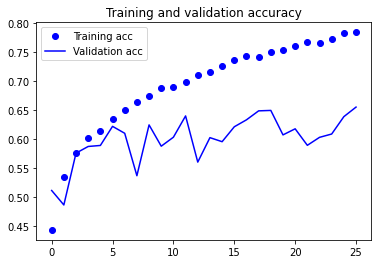

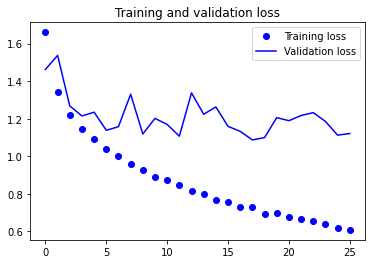

In [ ]:
show_curves(history)

125/125 [==============================] - 3s 16ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.51      0.53      0.52       375
           1       0.44      0.38      0.41       257
           2       0.62      0.70      0.65       188
           3       0.63      0.89      0.73       299
           4       0.39      0.51      0.44        35
           5       0.29      0.55      0.38        49
           6       0.27      0.45      0.33        49
           7       0.91      0.73      0.81      2000
           8       0.33      0.48      0.39       165
           9       0.51      0.59      0.55       211
          10       0.15      0.40      0.22        40
          11       0.58      0.56      0.57       327

    accuracy                           0.66      3995
   macro avg       0.47      0.56      0.50      3995
weighted avg       0.71      0.66      0.67      3995



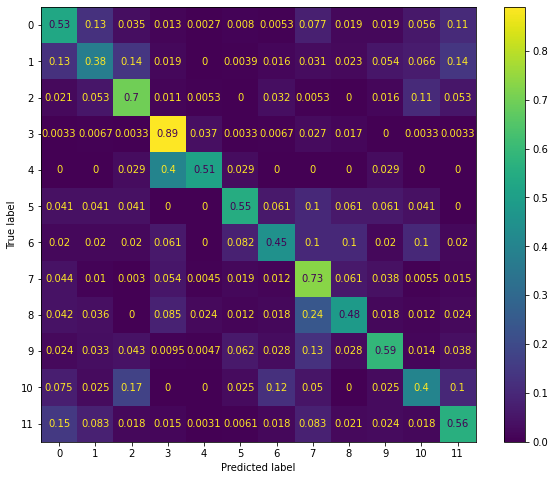

In [ ]:
evaluate_multiclass_model(save_path,test_dataset)

In [ ]:
save_model(model_name)

###Experiment 6: BN + Dropout

In [ ]:
inputs = keras.Input(shape=(80, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(1024) (x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Dense(512) (x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(12, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 80, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 80, 48, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 80, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 80, 48, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                             

In [ ]:
model_name = 'resnet_multi_BN_dropout.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/50


423/423 [==============================] - ETA: 0s - loss: 1.8709 - accuracy: 0.3929
Epoch 1: val_loss improved from inf to 1.62370, saving model to /content/resnet_multi_BN_dropout.h5
423/423 [==============================] - 69s 148ms/step - loss: 1.8709 - accuracy: 0.3929 - val_loss: 1.6237 - val_accuracy: 0.4461
Epoch 2/50
423/423 [==============================] - ETA: 0s - loss: 1.4802 - accuracy: 0.4958
Epoch 2: val_loss improved from 1.62370 to 1.31318, saving model to /content/resnet_multi_BN_dropout.h5
423/423 [==============================] - 64s 152ms/step - loss: 1.4802 - accuracy: 0.4958 - val_loss: 1.3132 - val_accuracy: 0.5484
Epoch 3/50
423/423 [==============================] - ETA: 0s - loss: 1.3287 - accuracy: 0.5412
Epoch 3: val_loss improved from 1.31318 to 1.28335, saving model to /content/resnet_multi_BN_dropout.h5
423/423 [==============================] - 62s 146ms/step - loss: 1.3287 - accuracy: 0.5412 - val_loss: 1.2834 - val_accuracy: 0.5549
Epoch 4/50
42

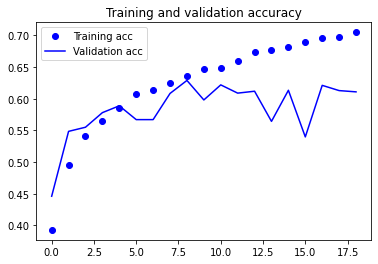

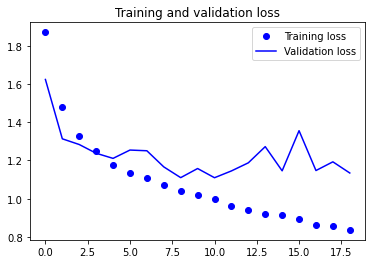

In [ ]:
show_curves(history)

In [ ]:
save_model('')

###Experiment 7: adding learning rate decay

In [ ]:
inputs = keras.Input(shape=(80, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(1024) (x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Dense(512) (x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
outputs = layers.Dense(12, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 80, 48, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 80, 48, 3)         0         
                                                                 
 tf.__operators__.getitem (S  (None, 80, 48, 3)        0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 80, 48, 3)        0         
                                                                 
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                             

In [ ]:
model_name = 'resnet_multi_BN_LR.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=9),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001, momentum=0.9),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/40


423/423 [==============================] - ETA: 0s - loss: 1.6438 - accuracy: 0.4468
Epoch 1: val_loss improved from inf to 1.60555, saving model to /content/resnet_multi_BN_LR.h5
423/423 [==============================] - 82s 155ms/step - loss: 1.6438 - accuracy: 0.4468 - val_loss: 1.6056 - val_accuracy: 0.4350 - lr: 0.0010
Epoch 2/40
423/423 [==============================] - ETA: 0s - loss: 1.3450 - accuracy: 0.5342
Epoch 2: val_loss improved from 1.60555 to 1.31479, saving model to /content/resnet_multi_BN_LR.h5
423/423 [==============================] - 63s 148ms/step - loss: 1.3450 - accuracy: 0.5342 - val_loss: 1.3148 - val_accuracy: 0.5589 - lr: 0.0010
Epoch 3/40
423/423 [==============================] - ETA: 0s - loss: 1.2232 - accuracy: 0.5709
Epoch 3: val_loss improved from 1.31479 to 1.30416, saving model to /content/resnet_multi_BN_LR.h5
423/423 [==============================] - 61s 144ms/step - loss: 1.2232 - accuracy: 0.5709 - val_loss: 1.3042 - val_accuracy: 0.5432 - 

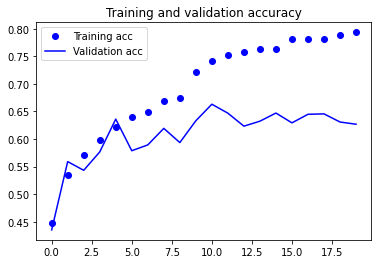

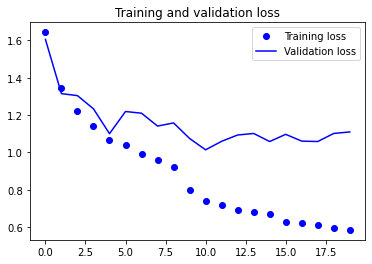

In [ ]:
show_curves(history)

125/125 [==============================] - 3s 16ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.61      0.47      0.53       375
           1       0.45      0.48      0.46       257
           2       0.70      0.63      0.66       188
           3       0.77      0.77      0.77       299
           4       0.36      0.63      0.46        35
           5       0.24      0.59      0.34        49
           6       0.35      0.57      0.44        49
           7       0.90      0.77      0.83      2000
           8       0.31      0.50      0.38       165
           9       0.49      0.63      0.55       211
          10       0.15      0.30      0.20        40
          11       0.57      0.64      0.60       327

    accuracy                           0.68      3995
   macro avg       0.49      0.58      0.52      3995
weighted avg       0.73      0.68      0.70      3995



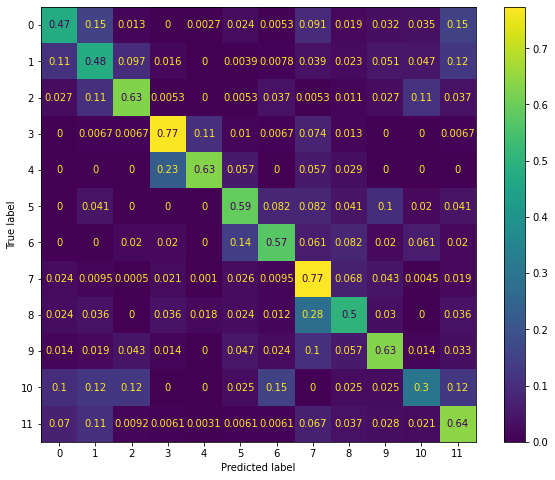

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)

Non ci sono miglioramenti rispetto al modello del quinto esperimento.

In [ ]:
save_model(model_name)

###Experiment 8: LR strategy + dropout

In [ ]:
inputs = keras.Input(shape=(80, 48, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(1024) (x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Dense(512) (x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Dropout(0.5) (x)
outputs = layers.Dense(12, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 80, 48, 3)]       0         
                                                                 
 sequential_2 (Sequential)   (None, 80, 48, 3)         0         
                                                                 
 tf.__operators__.getitem_4   (None, 80, 48, 3)        0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 80, 48, 3)        0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 3, 2, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 12288)             0   

In [ ]:
model_name = 'resnet_multi_BN_LR_dropout.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=9),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001, momentum=0.9),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/40


423/423 [==============================] - ETA: 0s - loss: 1.8739 - accuracy: 0.3971
Epoch 1: val_loss improved from inf to 1.54868, saving model to /content/resnet_multi_BN_LR_dropout.h5
423/423 [==============================] - 73s 158ms/step - loss: 1.8739 - accuracy: 0.3971 - val_loss: 1.5487 - val_accuracy: 0.4586 - lr: 0.0010
Epoch 2/40
423/423 [==============================] - ETA: 0s - loss: 1.4830 - accuracy: 0.4956
Epoch 2: val_loss improved from 1.54868 to 1.34097, saving model to /content/resnet_multi_BN_LR_dropout.h5
423/423 [==============================] - 65s 154ms/step - loss: 1.4830 - accuracy: 0.4956 - val_loss: 1.3410 - val_accuracy: 0.5504 - lr: 0.0010
Epoch 3/40
423/423 [==============================] - ETA: 0s - loss: 1.3397 - accuracy: 0.5382
Epoch 3: val_loss improved from 1.34097 to 1.26389, saving model to /content/resnet_multi_BN_LR_dropout.h5
423/423 [==============================] - 66s 155ms/step - loss: 1.3397 - accuracy: 0.5382 - val_loss: 1.2639 -

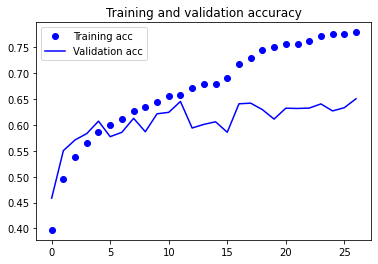

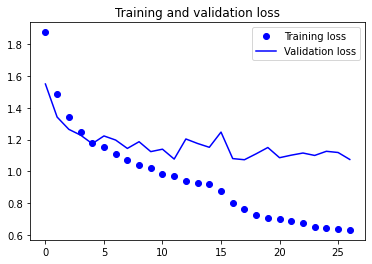

In [ ]:
show_curves(history)

125/125 [==============================] - 3s 16ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.61      0.50      0.55       375
           1       0.48      0.44      0.46       257
           2       0.68      0.57      0.62       188
           3       0.73      0.82      0.77       299
           4       0.38      0.57      0.46        35
           5       0.22      0.61      0.32        49
           6       0.30      0.53      0.38        49
           7       0.91      0.72      0.80      2000
           8       0.30      0.56      0.39       165
           9       0.42      0.64      0.51       211
          10       0.14      0.40      0.21        40
          11       0.56      0.62      0.59       327

    accuracy                           0.65      3995
   macro avg       0.48      0.58      0.50      3995
weighted avg       0.72      0.65      0.67      3995



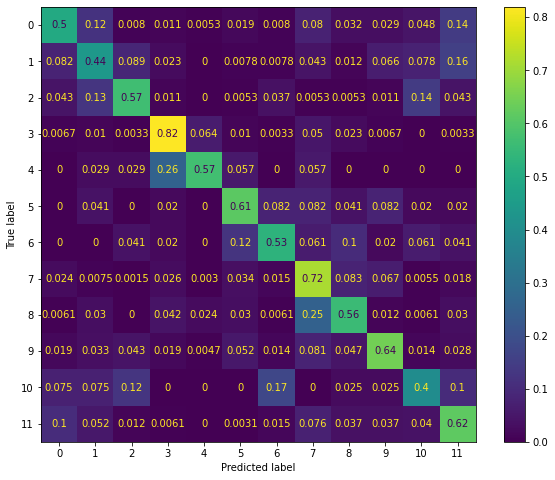

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)

##Fine tuning

I migliori risultati sono stati ottenuti nei casi 5 e 7. Questi modelli saranno quindi la base per il fine tuning.

###Unfreezing the last layer

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/CIDL Project/saved_models/resnet_multi_BN_LR.h5')

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv5_block3_3_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for i, layer in enumerate(model.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model_name = 'resnet_multi_fine_tuning.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=9),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001, momentum=0.9),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=55,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/55


423/423 [==============================] - ETA: 0s - loss: 1.0374 - accuracy: 0.6450
Epoch 1: val_loss improved from inf to 1.36459, saving model to /content/resnet_multi_fine_tuning.h5
423/423 [==============================] - 87s 159ms/step - loss: 1.0374 - accuracy: 0.6450 - val_loss: 1.3646 - val_accuracy: 0.5352 - lr: 0.0010
Epoch 2/55
423/423 [==============================] - ETA: 0s - loss: 0.8761 - accuracy: 0.6916
Epoch 2: val_loss improved from 1.36459 to 1.19477, saving model to /content/resnet_multi_fine_tuning.h5
423/423 [==============================] - 62s 146ms/step - loss: 0.8761 - accuracy: 0.6916 - val_loss: 1.1948 - val_accuracy: 0.6083 - lr: 0.0010
Epoch 3/55
423/423 [==============================] - ETA: 0s - loss: 0.7994 - accuracy: 0.7156
Epoch 3: val_loss did not improve from 1.19477
423/423 [==============================] - 64s 151ms/step - loss: 0.7994 - accuracy: 0.7156 - val_loss: 1.2047 - val_accuracy: 0.6100 - lr: 0.0010
Epoch 4/55
423/423 [=========

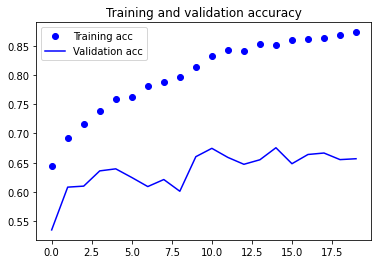

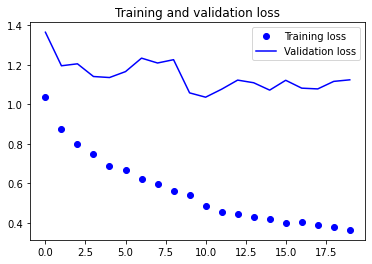

In [ ]:
show_curves(history)

125/125 [==============================] - 3s 17ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.59      0.51      0.55       375
           1       0.43      0.46      0.44       257
           2       0.62      0.58      0.60       188
           3       0.75      0.85      0.80       299
           4       0.51      0.60      0.55        35
           5       0.33      0.59      0.42        49
           6       0.39      0.53      0.45        49
           7       0.90      0.76      0.83      2000
           8       0.32      0.55      0.40       165
           9       0.51      0.64      0.57       211
          10       0.18      0.30      0.23        40
          11       0.57      0.67      0.62       327

    accuracy                           0.68      3995
   macro avg       0.51      0.59      0.54      3995
weighted avg       0.72      0.68      0.70      3995



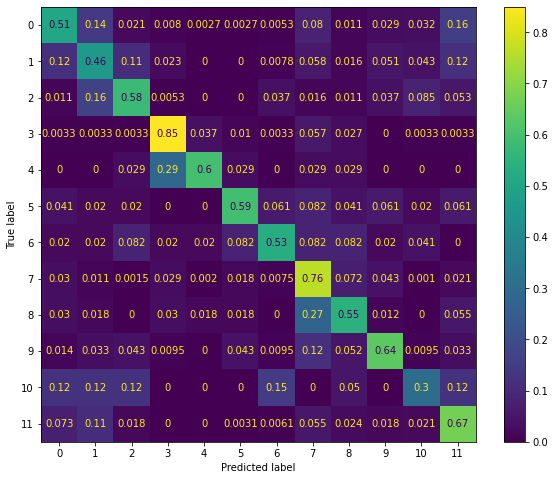

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)

In [ ]:
save_model(model_name)

###Unfreezing the last block



In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/CIDL Project/saved_models/resnet_multi_BN_LR.h5')

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv5_block3_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for i, layer in enumerate(model.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model_name = 'resnet_multi_fine_tuning_last_block.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=9),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001, momentum=0.9),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=55,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/55


423/423 [==============================] - ETA: 0s - loss: 1.0029 - accuracy: 0.6597
Epoch 1: val_loss improved from inf to 1.17530, saving model to /content/resnet_multi_fine_tuning_last_block.h5
423/423 [==============================] - 76s 156ms/step - loss: 1.0029 - accuracy: 0.6597 - val_loss: 1.1753 - val_accuracy: 0.6245 - lr: 0.0010
Epoch 2/55
423/423 [==============================] - ETA: 0s - loss: 0.8801 - accuracy: 0.6879
Epoch 2: val_loss did not improve from 1.17530
423/423 [==============================] - 63s 148ms/step - loss: 0.8801 - accuracy: 0.6879 - val_loss: 1.2900 - val_accuracy: 0.6005 - lr: 0.0010
Epoch 3/55
423/423 [==============================] - ETA: 0s - loss: 0.8496 - accuracy: 0.7001
Epoch 3: val_loss did not improve from 1.17530
423/423 [==============================] - 63s 149ms/step - loss: 0.8496 - accuracy: 0.7001 - val_loss: 1.1882 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 4/55
423/423 [==============================] - ETA: 0s - loss: 0.8345

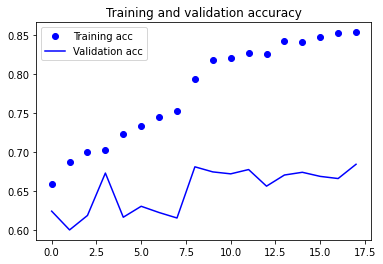

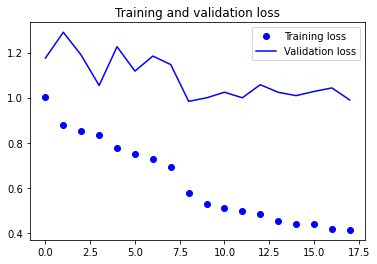

In [ ]:
show_curves(history)

125/125 [==============================] - 3s 16ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.57      0.55      0.56       375
           1       0.43      0.46      0.44       257
           2       0.64      0.69      0.66       188
           3       0.82      0.86      0.84       299
           4       0.57      0.66      0.61        35
           5       0.24      0.61      0.35        49
           6       0.31      0.55      0.40        49
           7       0.92      0.78      0.84      2000
           8       0.39      0.54      0.45       165
           9       0.52      0.58      0.55       211
          10       0.16      0.35      0.22        40
          11       0.57      0.61      0.59       327

    accuracy                           0.69      3995
   macro avg       0.51      0.60      0.54      3995
weighted avg       0.74      0.69      0.71      3995



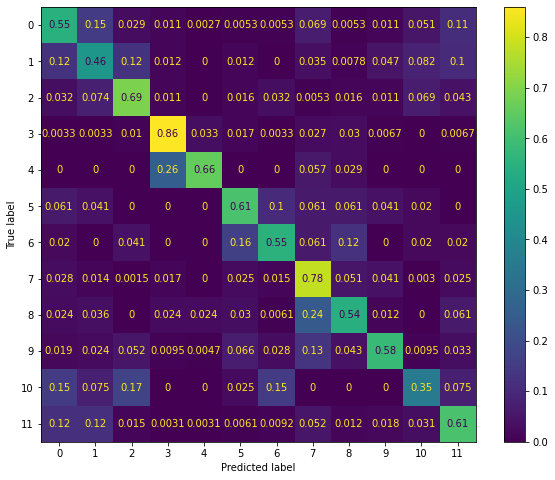

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)

In [ ]:
save_model(model_name)

###Unfreezing last 5 blocks

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/CIDL Project/saved_models/resnet_multi_BN_LR.h5')

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv4_block5_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for i, layer in enumerate(model.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model_name = 'resnet_multi_fine_tuning_last_5_blocks_bis.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=9),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001, momentum=0.9),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=55,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/55


423/423 [==============================] - ETA: 0s - loss: 1.4558 - accuracy: 0.5168
Epoch 1: val_loss improved from inf to 1.24625, saving model to /content/resnet_multi_fine_tuning_last_5_blocks_bis.h5
423/423 [==============================] - 88s 167ms/step - loss: 1.4558 - accuracy: 0.5168 - val_loss: 1.2462 - val_accuracy: 0.5657 - lr: 0.0010
Epoch 2/55
423/423 [==============================] - ETA: 0s - loss: 1.1313 - accuracy: 0.6041
Epoch 2: val_loss did not improve from 1.24625
423/423 [==============================] - 67s 157ms/step - loss: 1.1313 - accuracy: 0.6041 - val_loss: 2.1164 - val_accuracy: 0.5895 - lr: 0.0010
Epoch 3/55
423/423 [==============================] - ETA: 0s - loss: 1.0035 - accuracy: 0.6428
Epoch 3: val_loss improved from 1.24625 to 1.11471, saving model to /content/resnet_multi_fine_tuning_last_5_blocks_bis.h5
423/423 [==============================] - 68s 161ms/step - loss: 1.0035 - accuracy: 0.6428 - val_loss: 1.1147 - val_accuracy: 0.6293 - lr: 

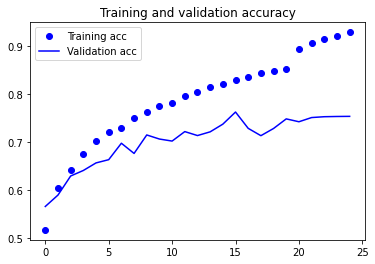

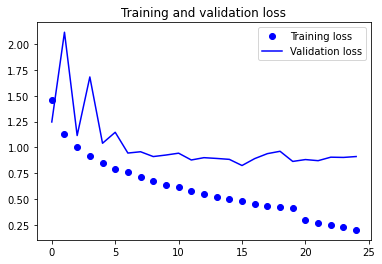

In [ ]:
show_curves(history)

125/125 [==============================] - 3s 16ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       375
           1       0.58      0.34      0.43       257
           2       0.65      0.70      0.68       188
           3       0.89      0.93      0.91       299
           4       0.80      0.69      0.74        35
           5       0.40      0.65      0.50        49
           6       0.41      0.49      0.44        49
           7       0.93      0.87      0.90      2000
           8       0.47      0.56      0.51       165
           9       0.57      0.70      0.63       211
          10       0.16      0.30      0.21        40
          11       0.61      0.73      0.67       327

    accuracy                           0.76      3995
   macro avg       0.59      0.63      0.60      3995
weighted avg       0.78      0.76      0.77      3995



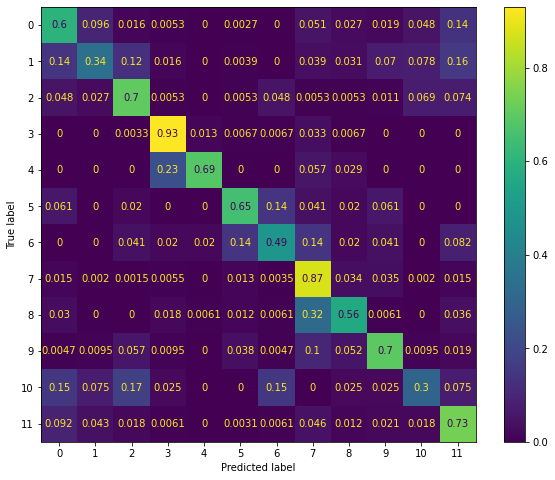

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)

In [ ]:
save_model(model_name)

###Unfreezing last 6 blocks

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/CIDL Project/saved_models/resnet_multi_BN_LR.h5')

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv4_block4_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for i, layer in enumerate(model.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model_name = 'resnet_multi_fine_tuning_last_6_blocks_bis.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=9),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001, momentum=0.9),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=70,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/70
423/423 [==============================] - ETA: 0s - loss: 1.4706 - accuracy: 0.5127
Epoch 1: val_loss improved from inf to 1.44338, saving model to /content/resnet_multi_fine_tuning_last_6_blocks_bis.h5
423/423 [==============================] - 54s 59ms/step - loss: 1.4706 - accuracy: 0.5127 - val_loss: 1.4434 - val_accuracy: 0.6270 - lr: 0.0010
Epoch 2/70
422/423 [============================>.] - ETA: 0s - loss: 1.1295 - accuracy: 0.6051
Epoch 2: val_loss improved from 1.44338 to 1.06991, saving model to /content/resnet_multi_fine_tuning_last_6_blocks_bis.h5
423/423 [==============================] - 22s 53ms/step - loss: 1.1291 - accuracy: 0.6052 - val_loss: 1.0699 - val_accuracy: 0.6108 - lr: 0.0010
Epoch 3/70
422/423 [============================>.] - ETA: 0s - loss: 1.0356 - accuracy: 0.6374
Epoch 3: val_loss did not improve from 1.06991
423/423 [==============================] - 20s 48ms/step - loss: 1.0354 - accuracy: 0.6375 - val_loss: 1.0913 - val_accuracy: 0.635

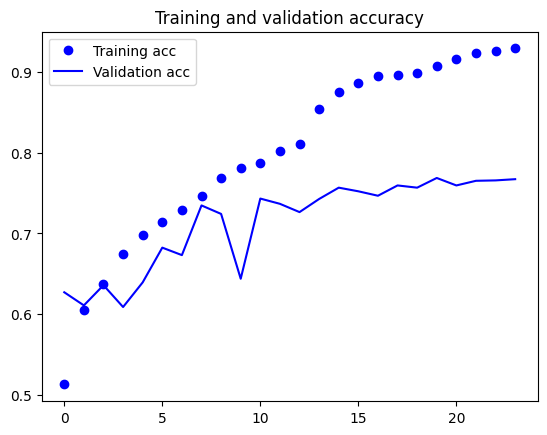

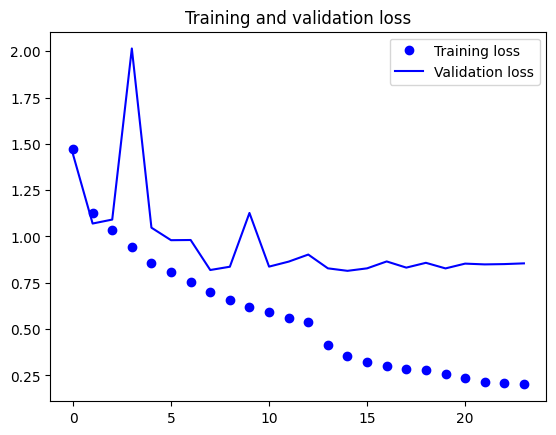

In [ ]:
show_curves(history)

125/125 [==============================] - 3s 15ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       375
           1       0.54      0.54      0.54       257
           2       0.66      0.66      0.66       188
           3       0.92      0.94      0.93       299
           4       0.78      0.80      0.79        35
           5       0.39      0.76      0.52        49
           6       0.43      0.59      0.50        49
           7       0.94      0.83      0.88      2000
           8       0.41      0.58      0.48       165
           9       0.59      0.68      0.63       211
          10       0.22      0.35      0.27        40
          11       0.61      0.69      0.65       327

    accuracy                           0.75      3995
   macro avg       0.59      0.67      0.62      3995
weighted avg       0.78      0.75      0.76      3995



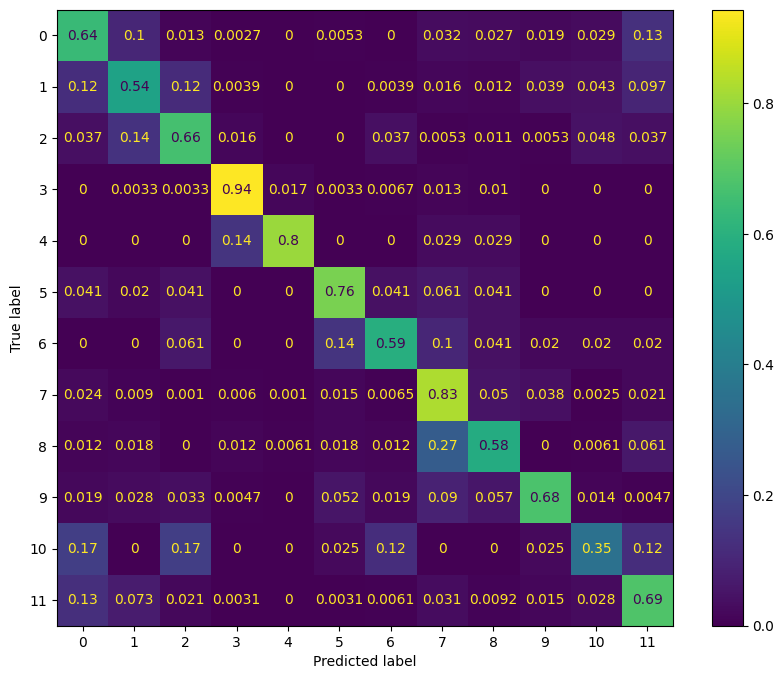

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)

In [ ]:
save_model(model_name)

###Unfreezing last 5 blocks with fixed LR

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/CIDL Project/saved_models/resnet_multi_BN_LR.h5')

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv4_block5_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for i, layer in enumerate(model.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model_name = 'resnet_multi_fine_tuning_last_5_blocks_bis_noLR.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=9),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=55,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/55


423/423 [==============================] - ETA: 0s - loss: 1.4588 - accuracy: 0.5111
Epoch 1: val_loss improved from inf to 1.91677, saving model to /content/resnet_multi_fine_tuning_last_5_blocks_bis_noLR.h5
423/423 [==============================] - 86s 164ms/step - loss: 1.4588 - accuracy: 0.5111 - val_loss: 1.9168 - val_accuracy: 0.5244
Epoch 2/55
423/423 [==============================] - ETA: 0s - loss: 1.1305 - accuracy: 0.6098
Epoch 2: val_loss improved from 1.91677 to 1.81885, saving model to /content/resnet_multi_fine_tuning_last_5_blocks_bis_noLR.h5
423/423 [==============================] - 68s 160ms/step - loss: 1.1305 - accuracy: 0.6098 - val_loss: 1.8188 - val_accuracy: 0.6040
Epoch 3/55
423/423 [==============================] - ETA: 0s - loss: 1.0229 - accuracy: 0.6420
Epoch 3: val_loss improved from 1.81885 to 1.13315, saving model to /content/resnet_multi_fine_tuning_last_5_blocks_bis_noLR.h5
423/423 [==============================] - 68s 162ms/step - loss: 1.0229 - 

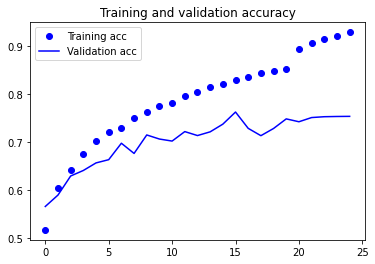

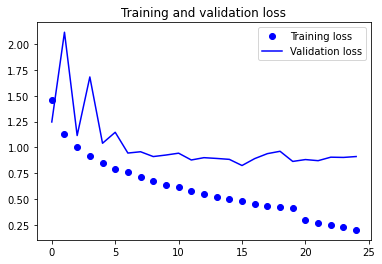

In [ ]:
show_curves(history)

125/125 [==============================] - 4s 22ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.62      0.55      0.58       375
           1       0.48      0.48      0.48       257
           2       0.71      0.60      0.65       188
           3       0.88      0.94      0.91       299
           4       0.77      0.77      0.77        35
           5       0.38      0.76      0.50        49
           6       0.51      0.51      0.51        49
           7       0.95      0.77      0.85      2000
           8       0.32      0.72      0.44       165
           9       0.51      0.68      0.58       211
          10       0.14      0.30      0.19        40
          11       0.58      0.69      0.63       327

    accuracy                           0.71      3995
   macro avg       0.57      0.65      0.59      3995
weighted avg       0.77      0.71      0.73      3995



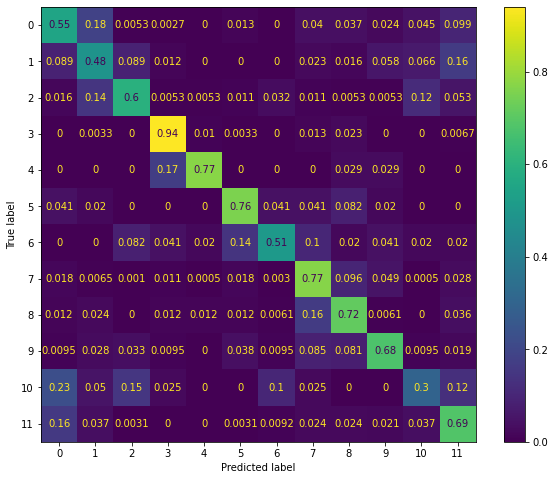

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)

###Unfreezing the last 3 blocks (base model 5)

Proviamo il fine tuning anche usando come modello base quello trovato allo step 5 di "Feature extraction"

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/CIDL Project/saved_models/resnet_multi_BN.h5')

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for i, layer in enumerate(model.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model_name = 'resnet_multi_fine_tuning_last_3_blocks.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=55,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/55


423/423 [==============================] - ETA: 0s - loss: 1.4186 - accuracy: 0.5428
Epoch 1: val_loss improved from inf to 1.62467, saving model to /content/resnet_multi_fine_tuning_last_3_blocks.h5
423/423 [==============================] - 81s 164ms/step - loss: 1.4186 - accuracy: 0.5428 - val_loss: 1.6247 - val_accuracy: 0.6220
Epoch 2/55
423/423 [==============================] - ETA: 0s - loss: 1.0638 - accuracy: 0.6292
Epoch 2: val_loss improved from 1.62467 to 1.04326, saving model to /content/resnet_multi_fine_tuning_last_3_blocks.h5
423/423 [==============================] - 68s 161ms/step - loss: 1.0638 - accuracy: 0.6292 - val_loss: 1.0433 - val_accuracy: 0.6428
Epoch 3/55
423/423 [==============================] - ETA: 0s - loss: 0.9447 - accuracy: 0.6646
Epoch 3: val_loss improved from 1.04326 to 1.02022, saving model to /content/resnet_multi_fine_tuning_last_3_blocks.h5
423/423 [==============================] - 67s 157ms/step - loss: 0.9447 - accuracy: 0.6646 - val_loss

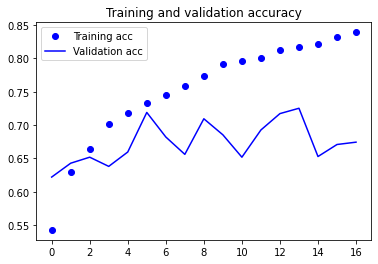

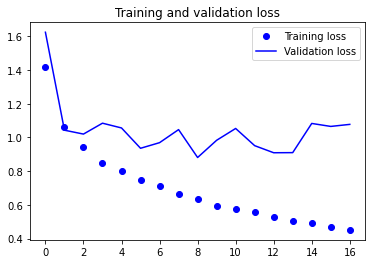

In [ ]:
show_curves(history)

125/125 [==============================] - 4s 21ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.63      0.49      0.55       375
           1       0.39      0.51      0.44       257
           2       0.60      0.47      0.53       188
           3       0.87      0.90      0.89       299
           4       0.71      0.71      0.71        35
           5       0.34      0.63      0.45        49
           6       0.40      0.63      0.49        49
           7       0.92      0.82      0.87      2000
           8       0.35      0.59      0.43       165
           9       0.57      0.63      0.60       211
          10       0.21      0.47      0.29        40
          11       0.60      0.59      0.60       327

    accuracy                           0.71      3995
   macro avg       0.55      0.62      0.57      3995
weighted avg       0.75      0.71      0.73      3995



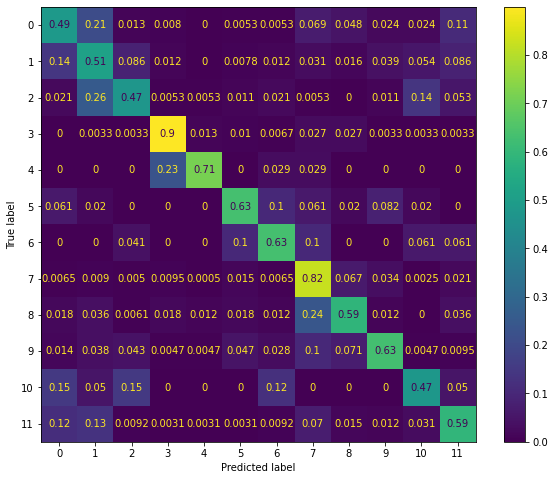

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)

In [ ]:
save_model(model_name)

### Unfreezing the last 4 blocks (base model 5)

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/CIDL Project/saved_models/resnet_multi_BN.h5')

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv4_block6_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for i, layer in enumerate(model.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model_name = 'resnet_multi_fine_tuning_last_4_blocks.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=55,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/55


423/423 [==============================] - ETA: 0s - loss: 1.4384 - accuracy: 0.5306
Epoch 1: val_loss improved from inf to 1.72326, saving model to /content/resnet_multi_fine_tuning_last_4_blocks.h5
423/423 [==============================] - 86s 165ms/step - loss: 1.4384 - accuracy: 0.5306 - val_loss: 1.7233 - val_accuracy: 0.5259
Epoch 2/55
423/423 [==============================] - ETA: 0s - loss: 1.1289 - accuracy: 0.6129
Epoch 2: val_loss did not improve from 1.72326
423/423 [==============================] - 66s 156ms/step - loss: 1.1289 - accuracy: 0.6129 - val_loss: 5.7503 - val_accuracy: 0.4581
Epoch 3/55
423/423 [==============================] - ETA: 0s - loss: 0.9814 - accuracy: 0.6576
Epoch 3: val_loss improved from 1.72326 to 1.54204, saving model to /content/resnet_multi_fine_tuning_last_4_blocks.h5
423/423 [==============================] - 69s 164ms/step - loss: 0.9814 - accuracy: 0.6576 - val_loss: 1.5420 - val_accuracy: 0.5902
Epoch 4/55
423/423 [====================

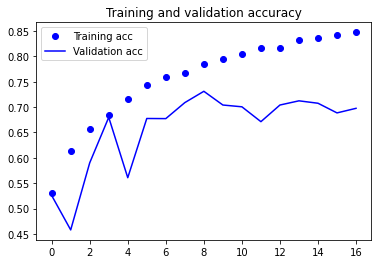

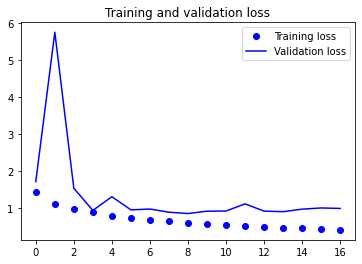

In [ ]:
show_curves(history)

125/125 [==============================] - 4s 21ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.57      0.50      0.53       375
           1       0.44      0.39      0.41       257
           2       0.66      0.63      0.64       188
           3       0.93      0.91      0.92       299
           4       0.64      0.80      0.71        35
           5       0.33      0.71      0.45        49
           6       0.35      0.59      0.44        49
           7       0.93      0.84      0.88      2000
           8       0.47      0.56      0.51       165
           9       0.60      0.69      0.64       211
          10       0.16      0.47      0.24        40
          11       0.60      0.66      0.63       327

    accuracy                           0.73      3995
   macro avg       0.56      0.65      0.59      3995
weighted avg       0.76      0.73      0.74      3995



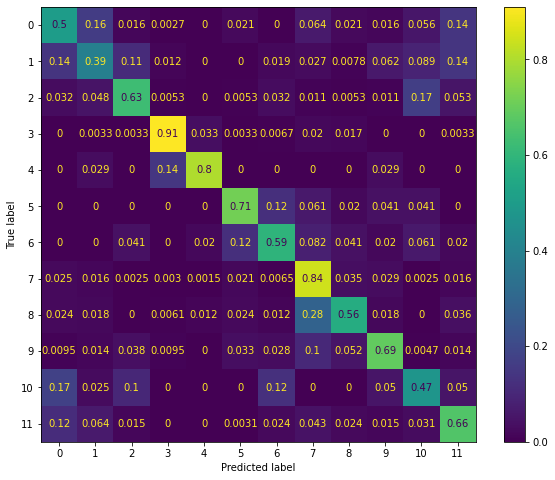

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)

In [ ]:
save_model(model_name)

###Unfreezing the last 5 blocks (base model 5)

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/CIDL Project/saved_models/resnet_multi_BN.h5')

set_trainable = False
for layer in model.get_layer('resnet50').layers:
    if layer.name == 'conv4_block5_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
for i, layer in enumerate(model.get_layer('resnet50').layers):
    print(i, layer.name, layer.trainable)


0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model_name = 'resnet_multi_fine_tuning_last_5_blocks.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=8),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=55,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/55


423/423 [==============================] - ETA: 0s - loss: 1.4546 - accuracy: 0.5223
Epoch 1: val_loss improved from inf to 1.17704, saving model to /content/resnet_multi_fine_tuning_last_5_blocks.h5
423/423 [==============================] - 86s 164ms/step - loss: 1.4546 - accuracy: 0.5223 - val_loss: 1.1770 - val_accuracy: 0.6203
Epoch 2/55
423/423 [==============================] - ETA: 0s - loss: 1.1067 - accuracy: 0.6154
Epoch 2: val_loss did not improve from 1.17704
423/423 [==============================] - 67s 158ms/step - loss: 1.1067 - accuracy: 0.6154 - val_loss: 1.2332 - val_accuracy: 0.5985
Epoch 3/55
423/423 [==============================] - ETA: 0s - loss: 0.9602 - accuracy: 0.6635
Epoch 3: val_loss did not improve from 1.17704
423/423 [==============================] - 66s 156ms/step - loss: 0.9602 - accuracy: 0.6635 - val_loss: 1.3160 - val_accuracy: 0.5582
Epoch 4/55
423/423 [==============================] - ETA: 0s - loss: 0.9243 - accuracy: 0.6804
Epoch 4: val_los

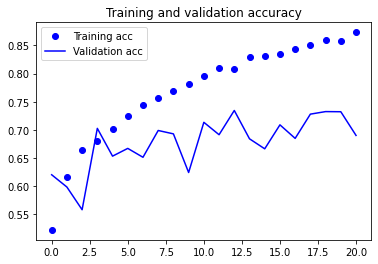

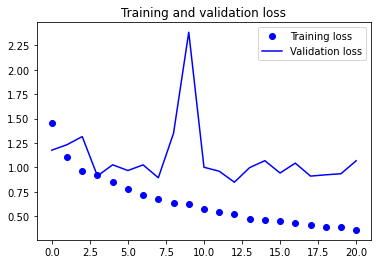

In [ ]:
show_curves(history)

125/125 [==============================] - 3s 16ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.64      0.61      0.62       375
           1       0.54      0.49      0.51       257
           2       0.68      0.65      0.66       188
           3       0.88      0.92      0.90       299
           4       0.79      0.66      0.72        35
           5       0.31      0.67      0.42        49
           6       0.43      0.53      0.47        49
           7       0.93      0.84      0.88      2000
           8       0.40      0.52      0.45       165
           9       0.64      0.66      0.65       211
          10       0.19      0.33      0.24        40
          11       0.58      0.75      0.65       327

    accuracy                           0.75      3995
   macro avg       0.58      0.63      0.60      3995
weighted avg       0.78      0.75      0.76      3995



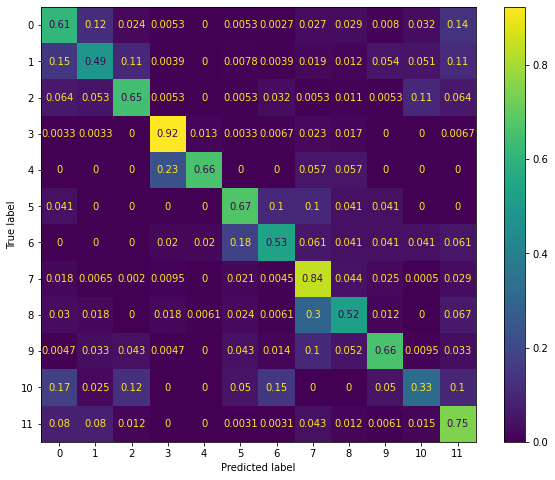

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)

In [ ]:
save_model(model_name)

# Remove blocks

In [ ]:
resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(80, 48, 3))



In [ ]:
resnet.trainable = False

In [ ]:


# Select the layers to keep
layers_to_keep = 11
x = data_augmentation(inputs)
x = resnet.layers[-layers_to_keep].output

x = keras.layers.Flatten()(x)
x = layers.Dense(1024) (x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
x = layers.Dense(512) (x)
x = layers.BatchNormalization()(x)
x = keras.activations.relu(x)
outputs = layers.Dense(12, activation="softmax")(x)

# Create a new model with the modified ResNet50 architecture
model = Model(resnet.input, outputs)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 80, 48, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 86, 54, 3)    0           ['input_16[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 40, 24, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 40, 24, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

In [ ]:
layer_list = model.layers
for layer in layer_list:
    print(layer.name)


input_16
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3

In [ ]:
model_name = 'resnet_multi_rem_block.h5'
save_path = '/content/' + model_name

callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=9),
                  keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.0001, momentum=0.9),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor='val_loss',
                      verbose=1,
                      save_best_only=True)
                  ]

history = model.fit(train_dataset,
                    epochs=40,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)

Epoch 1/40
423/423 [==============================] - ETA: 0s - loss: 1.4093 - accuracy: 0.5255
Epoch 1: val_loss improved from inf to 1.50085, saving model to /content/resnet_multi_rem_block.h5
423/423 [==============================] - 33s 41ms/step - loss: 1.4093 - accuracy: 0.5255 - val_loss: 1.5009 - val_accuracy: 0.5071 - lr: 0.0010
Epoch 2/40
422/423 [============================>.] - ETA: 0s - loss: 0.8834 - accuracy: 0.6922
Epoch 2: val_loss improved from 1.50085 to 1.35152, saving model to /content/resnet_multi_rem_block.h5
423/423 [==============================] - 14s 33ms/step - loss: 0.8830 - accuracy: 0.6924 - val_loss: 1.3515 - val_accuracy: 0.5584 - lr: 0.0010
Epoch 3/40
423/423 [==============================] - ETA: 0s - loss: 0.6189 - accuracy: 0.7874
Epoch 3: val_loss improved from 1.35152 to 1.29871, saving model to /content/resnet_multi_rem_block.h5
423/423 [==============================] - 12s 29ms/step - loss: 0.6189 - accuracy: 0.7874 - val_loss: 1.2987 - val

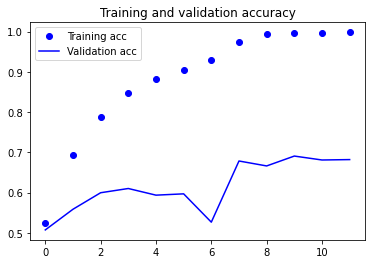

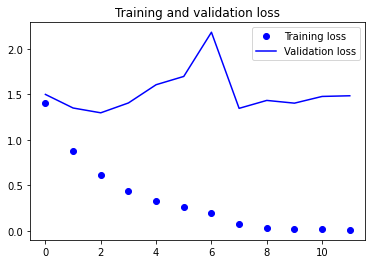

In [ ]:
show_curves(history)

125/125 [==============================] - 3s 15ms/step
Classification report: 
              precision    recall  f1-score   support

           0       0.57      0.44      0.50       375
           1       0.44      0.22      0.29       257
           2       0.63      0.64      0.64       188
           3       0.73      0.89      0.80       299
           4       0.47      0.86      0.61        35
           5       0.18      0.67      0.28        49
           6       0.33      0.65      0.44        49
           7       0.95      0.64      0.76      2000
           8       0.25      0.59      0.35       165
           9       0.44      0.66      0.52       211
          10       0.17      0.33      0.22        40
          11       0.47      0.78      0.59       327

    accuracy                           0.62      3995
   macro avg       0.47      0.61      0.50      3995
weighted avg       0.72      0.62      0.64      3995



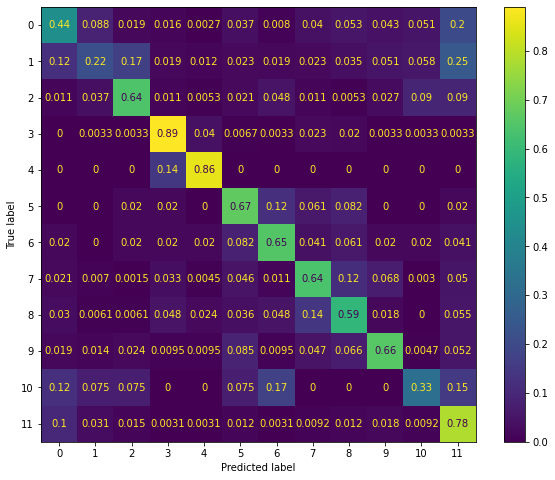

In [ ]:
evaluate_multiclass_model(save_path, test_dataset)